In [1]:
# import libraries
import pandas as pd
import geopandas as gpd 

import folium # sirve para hacer mapas interactivos
from folium import plugins 
from folium.plugins import HeatMap 

import matplotlib.pyplot as plt # superior en cuestion de rendimiento
import contextily as ctx # sirve para poner mapas de fondo
from pyproj import Transformer # sirve para transformar coordenadas

import seaborn as sns # para hacer graficos mas bonitos

import json 
import pydeck as pdk # for 3D maps, buen resultado, muy visual

from shapely.geometry import LineString, Point, box # sirve para hacer geometrias

In [2]:
# para que los graficos se vean en el notebook
%matplotlib inline 

In [3]:
# Variables globales
latitud = 41.155
longitud = -8.63
zoom = 13
nrows = 100000
# Ruta del archivo CSV
filename = "../train_data/taxis_trajectory/train.csv"

## Cargar archivos de datos

In [4]:
def load_and_simplify_data(filename, rows, tolerance=0.001):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    
    # Filtrar polilíneas vacías o con un solo punto
    def create_line(x):
        points = json.loads(x)
        if len(points) > 1:
            return LineString(points)
        return None

    df['geometry'] = df['POLYLINE'].apply(create_line)
    
    # Eliminar filas con geometrías nulas
    df = df[df['geometry'].notnull()]
    
    # Convertir a Geopandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Simplificar las geometrías
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)
    
    return gdf


In [5]:
# Cargar y simplificar datos (4:16 min 1.7M de filas)
gdf = load_and_simplify_data(filename, nrows)
gdf.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,geometry
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","LINESTRING (-8.61864 41.14141, -8.63275 41.146..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","LINESTRING (-8.63985 41.15983, -8.67085 41.165..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","LINESTRING (-8.61296 41.14036, -8.61421 41.140..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","LINESTRING (-8.57468 41.15195, -8.58074 41.145..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","LINESTRING (-8.64599 41.18049, -8.64680 41.178..."


## Implemetacion mapa con polilineas

Pruevas de mapa segmentado con y sin columna adicional, muy lento

In [6]:
"""  def plot_polylines_on_map(gdf, start_location, map_zoom_start=12):
    # Crear un mapa base
    m = folium.Map(location=start_location, zoom_start=map_zoom_start)

    # Añadir las polilíneas al mapa
    for _, row in gdf.iterrows():
        polyline = row['geometry'].coords[:]
        folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)

    return m """

"  def plot_polylines_on_map(gdf, start_location, map_zoom_start=12):\n    # Crear un mapa base\n    m = folium.Map(location=start_location, zoom_start=map_zoom_start)\n\n    # Añadir las polilíneas al mapa\n    for _, row in gdf.iterrows():\n        polyline = row['geometry'].coords[:]\n        folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)\n\n    return m "

In [7]:
# Prueva mapa segmetado con columna adicional, muy lento

""" # Definir una ubicación inicial para centrar el mapa (modifica con tus coordenadas)
start_location = [41.155, -8.63]

# Crear y mostrar el mapa
m = plot_polylines_on_map(gdf, start_location)
m """

' # Definir una ubicación inicial para centrar el mapa (modifica con tus coordenadas)\nstart_location = [41.155, -8.63]\n\n# Crear y mostrar el mapa\nm = plot_polylines_on_map(gdf, start_location)\nm '

In [8]:
# Prueva mapa segmetado sin columna adicional, muy lento

""" # Crear un mapa base
m = folium.Map(location=[latitud, longitud], zoom_start=zoom)

# Añadir las polilíneas
for _, row in gdf.iterrows():
    polyline = json.loads(row['POLYLINE'])
    folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)

# mostrar el mapa
m """

" # Crear un mapa base\nm = folium.Map(location=[latitud, longitud], zoom_start=zoom)\n\n# Añadir las polilíneas\nfor _, row in gdf.iterrows():\n    polyline = json.loads(row['POLYLINE'])\n    folium.PolyLine(polyline, color='blue', weight=2.5, opacity=1).add_to(m)\n\n# mostrar el mapa\nm "

Prueva de pydeck, la mas visual de todas pero es muy lento y pesado

In [9]:
# Prueva de pydeck, la mas visual de todas pero es muy lento y pesado

""" # Verificar el formato actual de 'POLYLINE'
gdf['POLYLINE'] = gdf['POLYLINE'].apply(json.loads)
print(gdf['POLYLINE'].head()) """

" # Verificar el formato actual de 'POLYLINE'\ngdf['POLYLINE'] = gdf['POLYLINE'].apply(json.loads)\nprint(gdf['POLYLINE'].head()) "

In [10]:
""" # Transformar cada línea en un diccionario
lines_data = [{"path": polyline, "color": [255, 0, 0]} for polyline in gdf['POLYLINE']]
lines_df = pd.DataFrame(lines_data)

# Configurar la vista inicial
view_state = pdk.ViewState(latitude=latitud, longitude=longitud, zoom=zoom)

# Crear la capa de líneas
layer = pdk.Layer(
    type="PathLayer",
    data=lines_df,
    get_path="path",
    get_color="color",
    width_min_pixels=2.5,
    pickable=True
)

# Renderizar el mapa
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show() """

' # Transformar cada línea en un diccionario\nlines_data = [{"path": polyline, "color": [255, 0, 0]} for polyline in gdf[\'POLYLINE\']]\nlines_df = pd.DataFrame(lines_data)\n\n# Configurar la vista inicial\nview_state = pdk.ViewState(latitude=latitud, longitude=longitud, zoom=zoom)\n\n# Crear la capa de líneas\nlayer = pdk.Layer(\n    type="PathLayer",\n    data=lines_df,\n    get_path="path",\n    get_color="color",\n    width_min_pixels=2.5,\n    pickable=True\n)\n\n# Renderizar el mapa\nr = pdk.Deck(layers=[layer], initial_view_state=view_state)\nr.show() '

Prueva geopamdas ,matplotlib y seaborn, la mas rapida pero no mustra mapa

In [11]:
# Prueva geopamdas ,matplotlib y seaborn, la mas rapida pero no mustra mapa

""" # Configurar el tamaño de la figura con Matplotlib
plt.rcParams['figure.figsize'] = [15, 8]

# Configurar el estilo de los gráficos con Seaborn
sns.set(style="darkgrid")

# Dibujar el gráfico
# Si tu GeoDataFrame tiene una columna 'geometry', la usamos directamente
gdf.plot(figsize=[15, 15])

# Configurar las etiquetas de los ejes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar el gráfico
# plt.show()

plt.savefig("mapa_visualizacion.png") """


' # Configurar el tamaño de la figura con Matplotlib\nplt.rcParams[\'figure.figsize\'] = [15, 8]\n\n# Configurar el estilo de los gráficos con Seaborn\nsns.set(style="darkgrid")\n\n# Dibujar el gráfico\n# Si tu GeoDataFrame tiene una columna \'geometry\', la usamos directamente\ngdf.plot(figsize=[15, 15])\n\n# Configurar las etiquetas de los ejes\nplt.xlabel(\'Longitude\')\nplt.ylabel(\'Latitude\')\n\n# Mostrar el gráfico\n# plt.show()\n\nplt.savefig("mapa_visualizacion.png") '

Prueva con folium y geopandas poner las polilineas encima, demasado lento

In [12]:
# Prueva con folium y geopandas poner las polilineas encima, demasado lento

"""
# Crear un mapa base en folium
m = folium.Map(location=[latitud, longitud], zoom_start=zoom)

# Dibujar las polilíneas en el mapa de Folium
for _, row in gdf.iterrows():
    # Asegúrate de que la geometría no es nula
    if row['geometry'] is not None:
        # Simplificar la geometría para mejorar la eficiencia
        simplified_line = row['geometry'].simplify(0.001)
        # Extraer las coordenadas de la línea
        line_coords = [[point[1], point[0]] for point in list(simplified_line.coords)]
        # Dibujar la línea en el mapa
        folium.PolyLine(line_coords, color='blue', weight=2.5, opacity=1).add_to(m)

# Mostrar el mapa
m.save('map.html')  # Guardar el mapa en un archivo HTML para visualizar en un navegador """


"\n# Crear un mapa base en folium\nm = folium.Map(location=[latitud, longitud], zoom_start=zoom)\n\n# Dibujar las polilíneas en el mapa de Folium\nfor _, row in gdf.iterrows():\n    # Asegúrate de que la geometría no es nula\n    if row['geometry'] is not None:\n        # Simplificar la geometría para mejorar la eficiencia\n        simplified_line = row['geometry'].simplify(0.001)\n        # Extraer las coordenadas de la línea\n        line_coords = [[point[1], point[0]] for point in list(simplified_line.coords)]\n        # Dibujar la línea en el mapa\n        folium.PolyLine(line_coords, color='blue', weight=2.5, opacity=1).add_to(m)\n\n# Mostrar el mapa\nm.save('map.html')  # Guardar el mapa en un archivo HTML para visualizar en un navegador "

Prueva con matplotlib y contextily, por ahora la mas rapida (2:14 archivo completo) (0:10 solo 100000 filas), no es la mas visula, el resultado es una imagen

In [13]:
def filter_data_in_area(gdf, minx, miny, maxx, maxy):
    # Crear un polígono de área de interés
    area_of_interest = box(minx, miny, maxx, maxy)
    
    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés
    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]
    
    return gdf_filtered

In [14]:
""" def solicitar_coordenadas():
    print("Por favor, introduce las coordenadas para el área de interés.")
    minx = float(input("Introduce la longitud mínima (minx): "))
    miny = float(input("Introduce la latitud mínima (miny): "))
    maxx = float(input("Introduce la longitud máxima (maxx): "))
    maxy = float(input("Introduce la latitud máxima (maxy): "))

    return minx, miny, maxx, maxy """

' def solicitar_coordenadas():\n    print("Por favor, introduce las coordenadas para el área de interés.")\n    minx = float(input("Introduce la longitud mínima (minx): "))\n    miny = float(input("Introduce la latitud mínima (miny): "))\n    maxx = float(input("Introduce la longitud máxima (maxx): "))\n    maxy = float(input("Introduce la latitud máxima (maxy): "))\n\n    return minx, miny, maxx, maxy '

Tras la modificacion de la funcion el tiempo de ejecucion es de 59 segundos las 100000 filas.

In [ ]:
# Solicitar al usuario las coordenada
# minx, miny, maxx, maxy = solicitar_coordenadas() 
minx=-8.689
miny=41.107
maxx=-8.560
maxy=41.185

In [24]:
gdf = gdf.set_crs("EPSG:4326")

# Luego, usar estas coordenadas en la función de filtrado
gdf_filtered = filter_data_in_area(gdf, minx, miny, maxx, maxy)

# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily
gdf_calibrate = gdf_filtered.to_crs(epsg=3857)
gdf_calibrate.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,geometry
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","LINESTRING (-959422.950 5033222.330, -960992.8..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","LINESTRING (-961783.369 5035944.622, -965234.8..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","LINESTRING (-958790.767 5033066.680, -958930.0..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","LINESTRING (-954528.789 5034780.303, -955204.0..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","LINESTRING (-959073.296 5033113.242, -957329.0..."


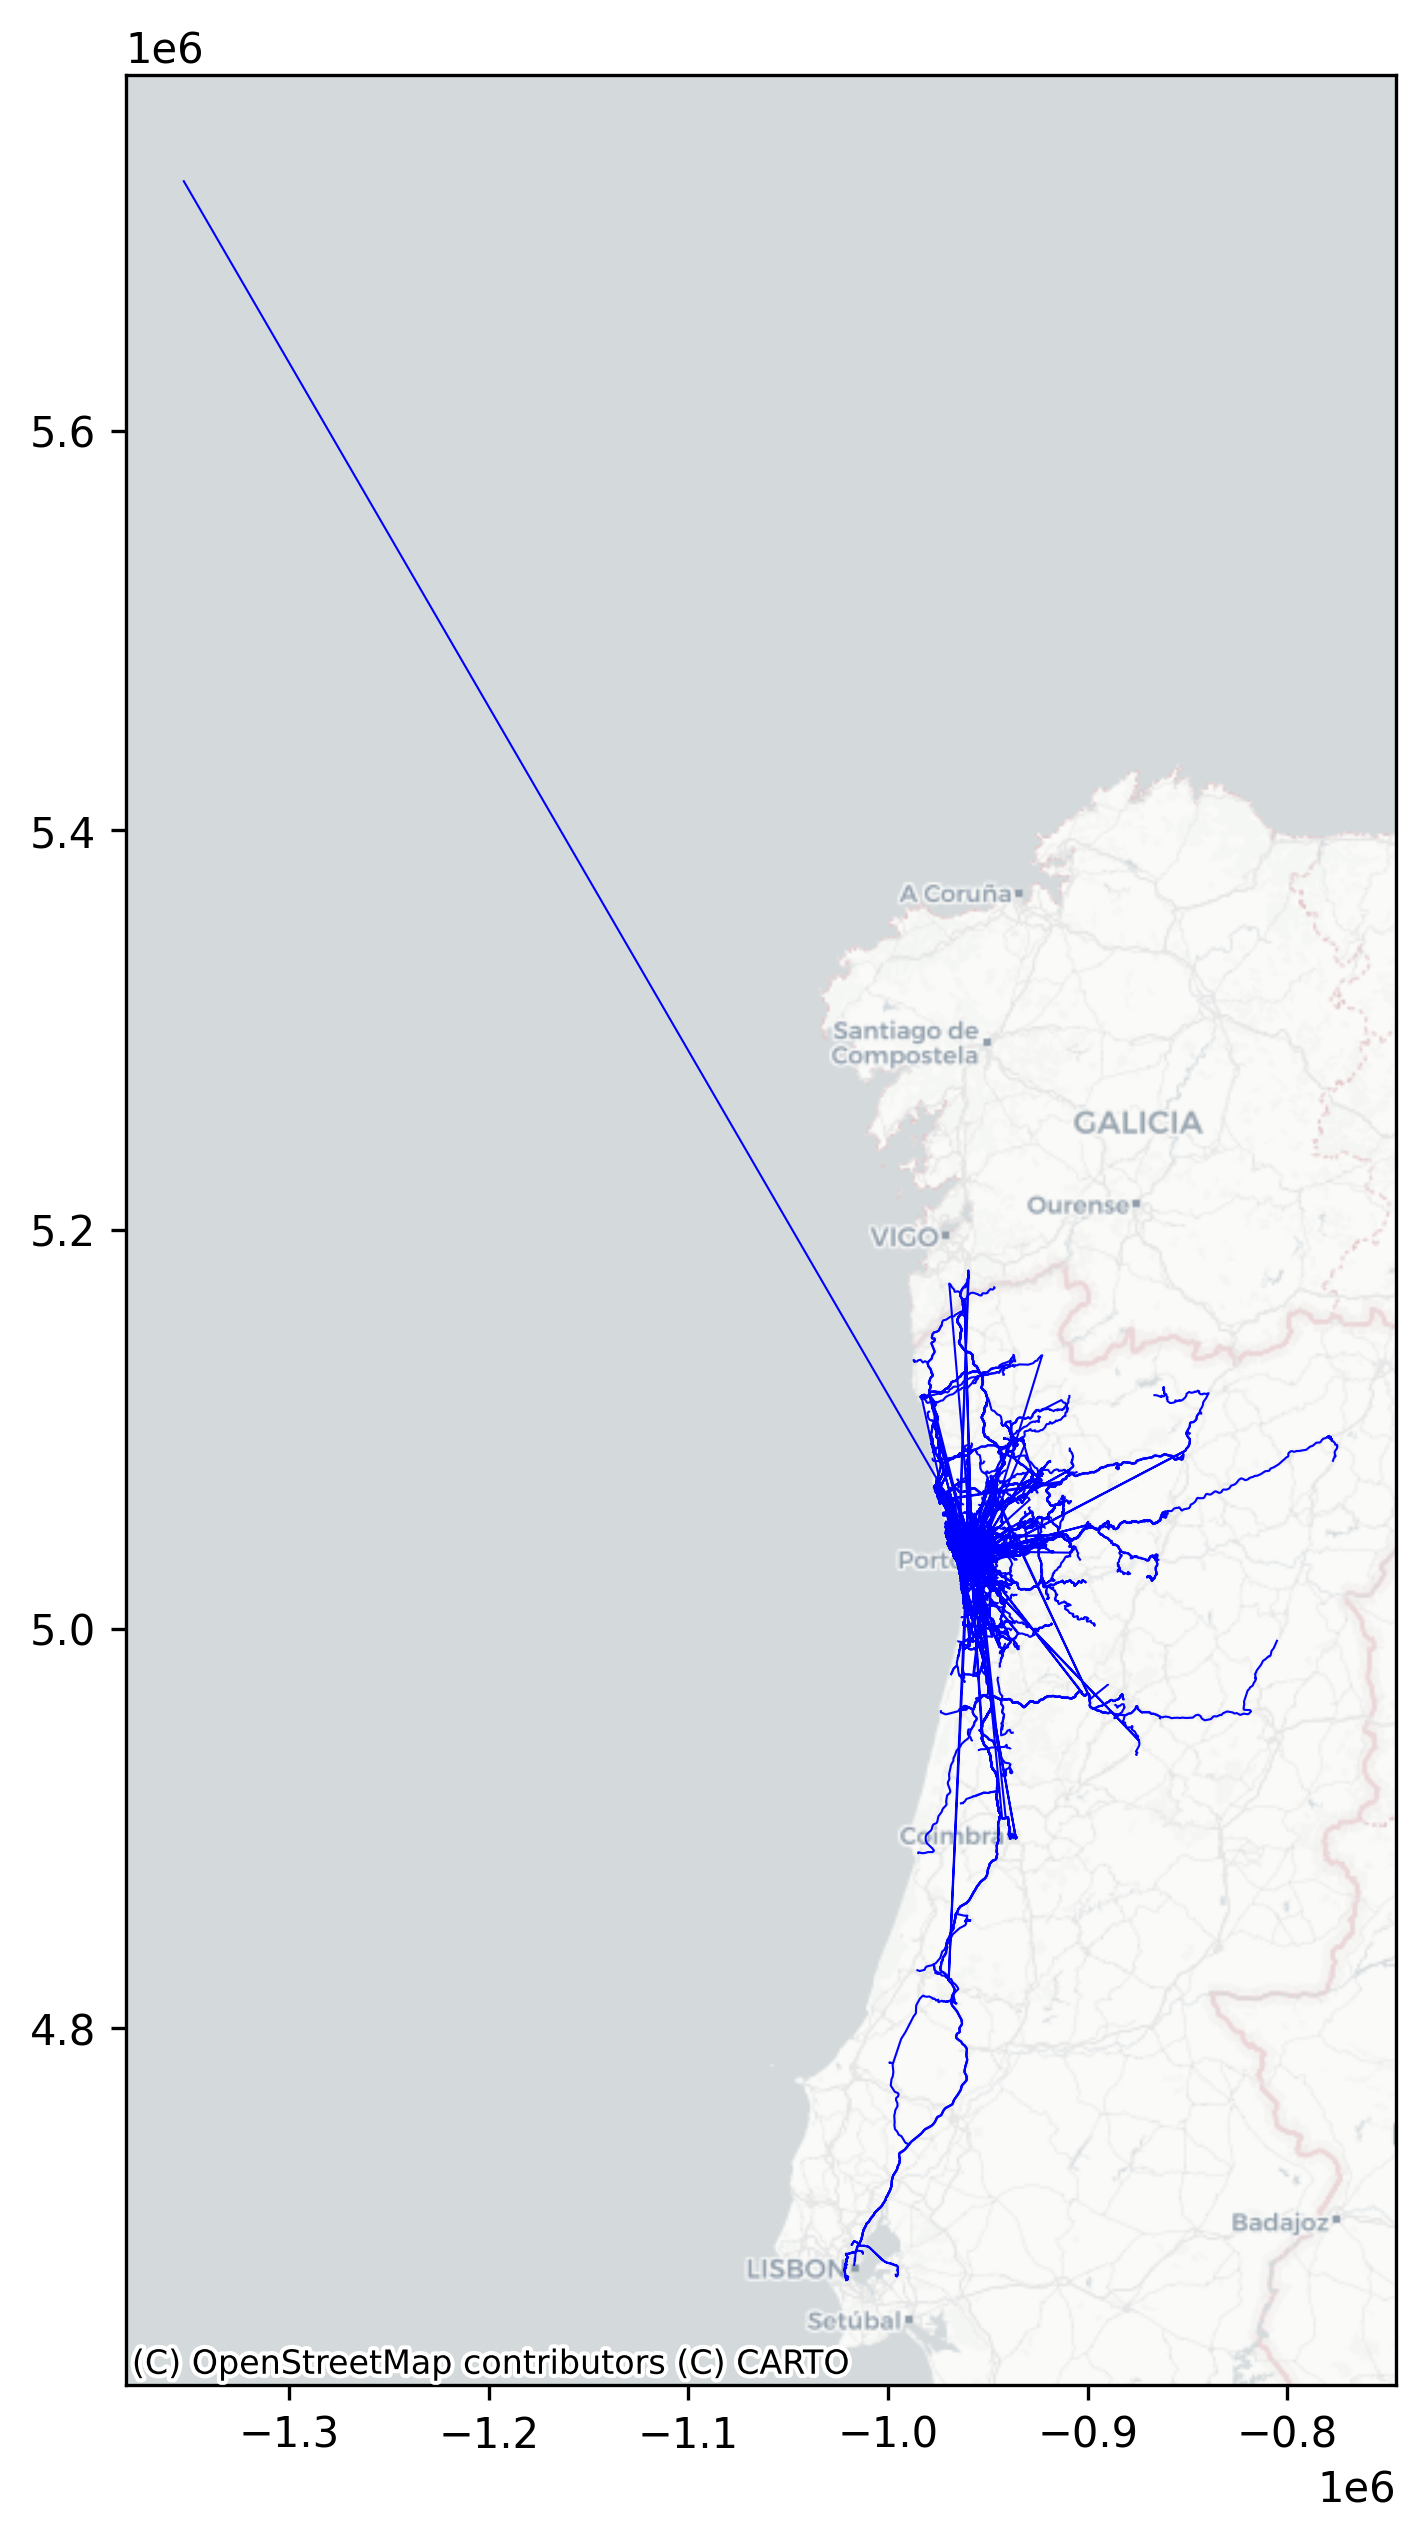

In [23]:
# Crear una figura con Matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
gdf_calibrate.plot(ax=ax, linewidth=0.5, color='blue')

# Añadir un mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Guardar la imagen
plt.savefig('map_overlay_filtered.png', bbox_inches='tight', pad_inches=0, transparent=True)

In [16]:
""" # Establecer el CRS a EPSG:4326 si los datos están en coordenadas longitud/latitud
gdf = gdf.set_crs("EPSG:4326")

# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily
gdf_calibrate = gdf.to_crs(epsg=3857) """

' # Establecer el CRS a EPSG:4326 si los datos están en coordenadas longitud/latitud\ngdf = gdf.set_crs("EPSG:4326")\n\n# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily\ngdf_calibrate = gdf.to_crs(epsg=3857) '

In [17]:
""" # Crear una figura con Matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
gdf_calibrate.plot(ax=ax, linewidth=0.5, color='blue')

# Añadir un mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Guardar la imagen con fondo transparente
plt.savefig('map_overlay.png', bbox_inches='tight', pad_inches=0, transparent=True) """

" # Crear una figura con Matplotlib\nfig, ax = plt.subplots(figsize=(10, 10), dpi=300)\ngdf_calibrate.plot(ax=ax, linewidth=0.5, color='blue')\n\n# Añadir un mapa base con Contextily\nctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)\n\n# Guardar la imagen con fondo transparente\nplt.savefig('map_overlay.png', bbox_inches='tight', pad_inches=0, transparent=True) "

In [18]:
""" def calcular_centro_y_zoom(minx, miny, maxx, maxy):
    # Calcular el centro
    centro = [(maxy + miny) / 2, (maxx + minx) / 2]

    return centro

# Calcular los límites y el centro para Folium
centro = calcular_centro_y_zoom(minx, miny, maxx, maxy)
bounds = [[miny, minx], [maxy, maxx]]

# Crear un mapa base en Folium
m = folium.Map(location=centro, zoom_start=zoom)

# Añadir la imagen como overlay en Folium
img = folium.raster_layers.ImageOverlay(
    name='Matplotlib Overlay',
    image='map_overlay_filtered.png',
    bounds=bounds,
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

img.add_to(m)
folium.LayerControl().add_to(m)

# Mostrar el mapa
m """

" def calcular_centro_y_zoom(minx, miny, maxx, maxy):\n    # Calcular el centro\n    centro = [(maxy + miny) / 2, (maxx + minx) / 2]\n\n    return centro\n\n# Calcular los límites y el centro para Folium\ncentro = calcular_centro_y_zoom(minx, miny, maxx, maxy)\nbounds = [[miny, minx], [maxy, maxx]]\n\n# Crear un mapa base en Folium\nm = folium.Map(location=centro, zoom_start=zoom)\n\n# Añadir la imagen como overlay en Folium\nimg = folium.raster_layers.ImageOverlay(\n    name='Matplotlib Overlay',\n    image='map_overlay_filtered.png',\n    bounds=bounds,\n    opacity=1,\n    interactive=True,\n    cross_origin=False,\n    zindex=1,\n)\n\nimg.add_to(m)\nfolium.LayerControl().add_to(m)\n\n# Mostrar el mapa\nm "

In [19]:
""" # Calcular los límites para Folium en EPSG:4326
bounds = [
    [gdf.total_bounds[1], gdf.total_bounds[0]],
    [gdf.total_bounds[3], gdf.total_bounds[2]]
]

# Crear un mapa base en Folium
m = folium.Map(location=[latitud, longitud], zoom_start=zoom)

# Añadir la imagen como overlay en Folium
img = folium.raster_layers.ImageOverlay(
    name='Matplotlib Overlay',
    image='map_overlay_filtered.png',
    bounds=bounds,
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=11,
)

img.add_to(m)
folium.LayerControl().add_to(m)

# Mostrar el mapa
m """

" # Calcular los límites para Folium en EPSG:4326\nbounds = [\n    [gdf.total_bounds[1], gdf.total_bounds[0]],\n    [gdf.total_bounds[3], gdf.total_bounds[2]]\n]\n\n# Crear un mapa base en Folium\nm = folium.Map(location=[latitud, longitud], zoom_start=zoom)\n\n# Añadir la imagen como overlay en Folium\nimg = folium.raster_layers.ImageOverlay(\n    name='Matplotlib Overlay',\n    image='map_overlay_filtered.png',\n    bounds=bounds,\n    opacity=1,\n    interactive=True,\n    cross_origin=False,\n    zindex=11,\n)\n\nimg.add_to(m)\nfolium.LayerControl().add_to(m)\n\n# Mostrar el mapa\nm "

## Implementacion mapa de calor

Prueva con folium y geopandas, muy rapido menos de un minuto archivo completo

In [20]:
def get_starting_points(gdf):
    # Inicializar una lista vacía para almacenar los puntos de inicio
    starting_points = []

    # Iterar sobre cada geometría en el GeoDataFrame
    for line in gdf['geometry']:
        # Verificar si la geometría es una LineString
        if isinstance(line, LineString):
            # Si es una LineString, obtener el primer punto (punto de inicio)
            start_point = Point(line.coords[0])
            starting_points.append(start_point)
        else:
            # Si no es una LineString, agregar None a la lista
            starting_points.append(None)

    # Convertir la lista de puntos de inicio en un GeoSeries y retornarla
    return gpd.GeoSeries(starting_points)

In [21]:
# Obtener los puntos de inicio
starting_points = get_starting_points(gdf)

# Asegurarse de que todos los elementos son de tipo Point y no None
# starting_points = starting_points[starting_points.notnull()]

# Convertir los puntos de inicio en un GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=starting_points)

In [22]:
# Crear un mapa base en Folium
m = folium.Map([latitud, longitud], zoom_start=zoom, tiles='cartodbpositron')

""" heat_data = []
    # Iterar sobre cada punto en la columna 'geometry' del GeoDataFrame
for point in gdf_points['geometry']:
    # Extraer las coordenadas 'y' (latitud) y 'x' (longitud) del punto
    coordinates = [point.y, point.x]

    # Añadir las coordenadas a la lista de datos del mapa de calor
    heat_data.append(coordinates) """
# Extraer las coordenadas x, y de los puntos para el mapa de calor
heat_data = [[point.y, point.x] for point in gdf_points['geometry']]

# Añadir el mapa de calor
HeatMap(heat_data).add_to(m)

# Mostrar el mapa
m 